In [1]:
# Simulation imports
from reporting import simulation
from reporting.simulation import NORTH, EAST, SOUTH, WEST
from reporting.plot_outbreak import plot_outbreak

In [2]:
# Library imports
import geopandas
import matplotlib
import shapely
from matplotlib import pyplot




# Day 1
## All the field reports have come in and it's time to analyse them

In [3]:
simulation.gather_reports_for_day_1()

### Let's grab the data directly from the database

In [4]:
from psycopg2 import connect
connection = connect(dbname='johnsnow')
cases = geopandas.read_postgis(
    "select * from reporting_report", connection,
    geom_col='location',
    crs={'init': 'epsg:4326'}
)


In [5]:
cases[['doctor_name', 'patient_name', 'diagnosis', 'location']].sample(5)

,doctor_name,patient_name,diagnosis,location
2,James Schneider,James Sanchez,rubella,POINT (-0.139037343128687 51.52482696282332)
58,Christine Chavez,David Lang,cholera,POINT (-0.1473893068430574 51.51789529675168)
25,Robert Doil,Martin Williams,rubella,POINT (-0.08674099118264492 51.53308811353376)
33,Judy Stone,Melissa Woods,typhoid,POINT (-0.1508683432721789 51.51982979904206)
20,Robert Gil,Mario Wallace,rubella,POINT (-0.08681692612089739 51.53366111632905)


### Now it's time to visualise them

In [6]:
# Set default size
matplotlib.rcParams['figure.figsize'] = [16.0, 12.0]

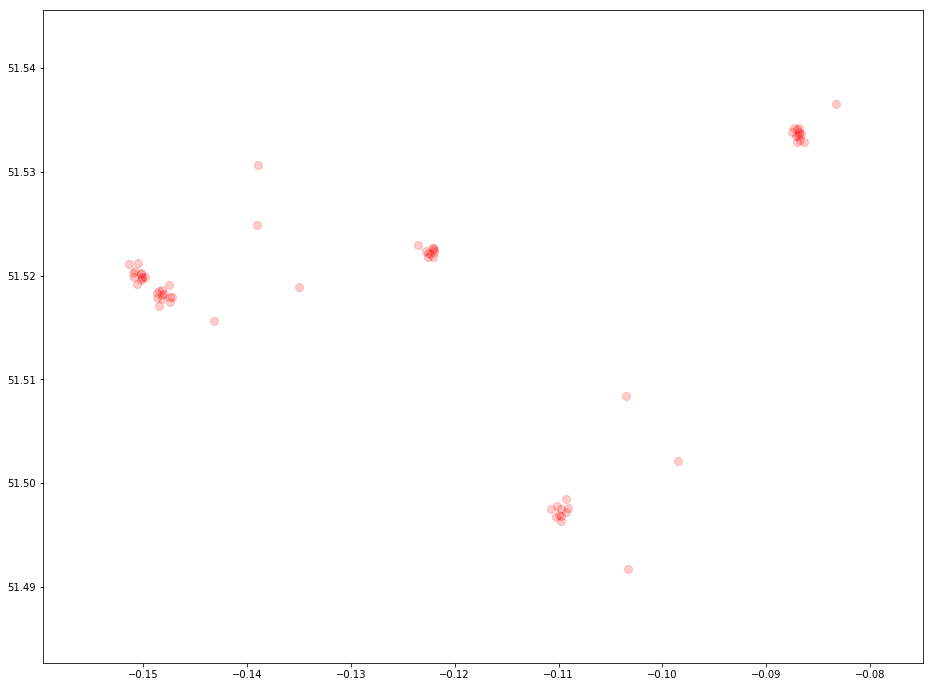

In [7]:
plot = cases.plot(marker="o", color="red", markersize=64, alpha=0.2)

### Let's distinguish different diagnoses

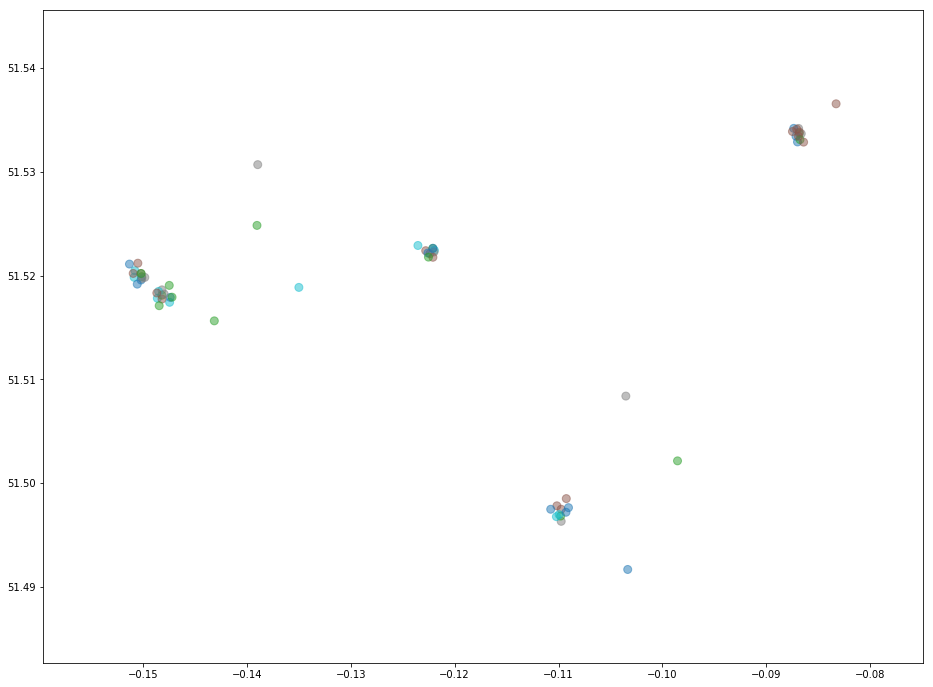

In [8]:
plot = cases.plot(marker="o", markersize=64, alpha=0.5, column='diagnosis')

### This data is useless without context. Let's map it

In [9]:
# Import London's rivers
rivers = geopandas.read_file('../open-street-map-data/london-rivers_shp/')

In [11]:
# Import London's roads
roads = geopandas.read_file('../open-street-map-data/london-roads_shp/')
# Filter the roads to just the most important ones
mains = roads[roads['highway'].isin(('trunk', 'primary', 'secondary', 'tertiary'))]

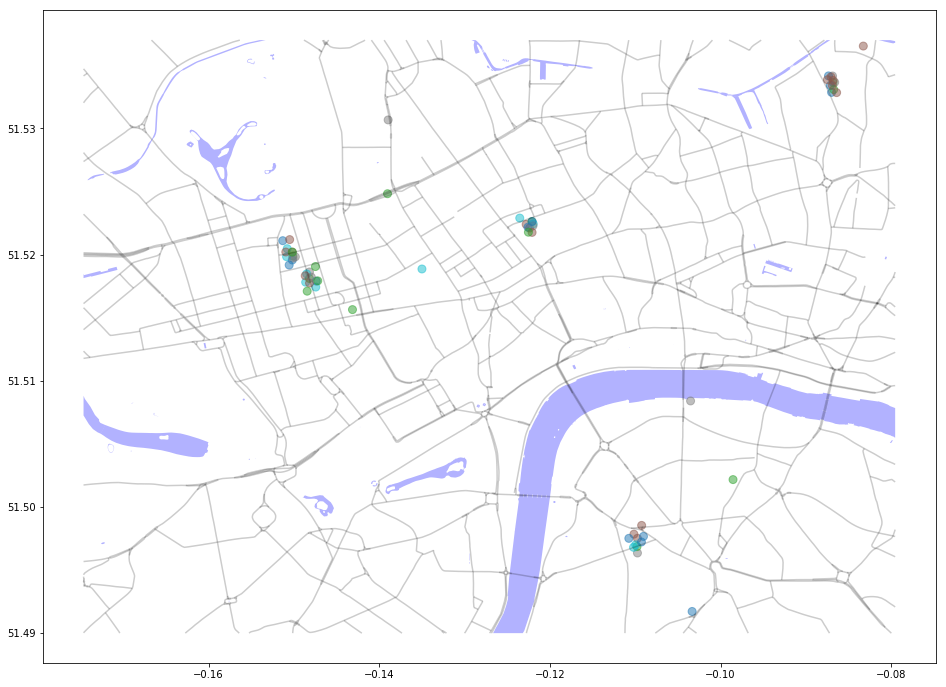

In [12]:
# Draw everything together
figure, axis = pyplot.subplots()
rivers_plot = rivers.plot(ax=axis, color='blue', alpha=0.3)
map_plot = mains.plot(ax=rivers_plot, color="black", alpha=0.2)
cases_plot = cases.plot(ax=map_plot, marker="o", column="diagnosis", markersize=64, alpha=0.5)

pyplot.show()

### What's going on? I have a hunch...

In [13]:
# Let's get open street map data about medical facilities
medical = geopandas.read_file('../open-street-map-data/london-medical_shp/')

# And use pandas filtering to select only the hospitals
hospitals = medical[medical['amenity'] == 'hospital'].copy()

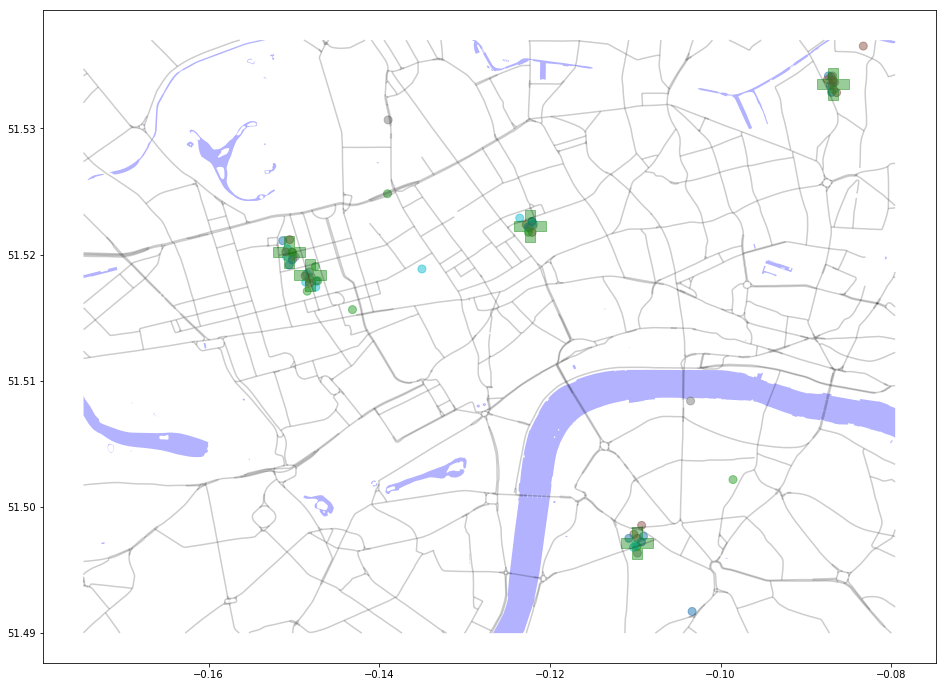

In [14]:
# Overlay our various geo-datasets
figure, axis = pyplot.subplots()
rivers_plot = rivers.plot(ax=axis, color='blue', alpha=0.3)
map_plot = mains.plot(ax=rivers_plot, color="black", alpha=0.2)
cases_plot = cases.plot(ax=map_plot, marker="o", column="diagnosis", markersize=64, alpha=0.5)

# Plot a green cross at the location of each hospital
final = hospitals.plot(ax=cases_plot, marker="P", markersize=1000, color="green", alpha=0.4)

pyplot.show()

### We need to improve our analysis

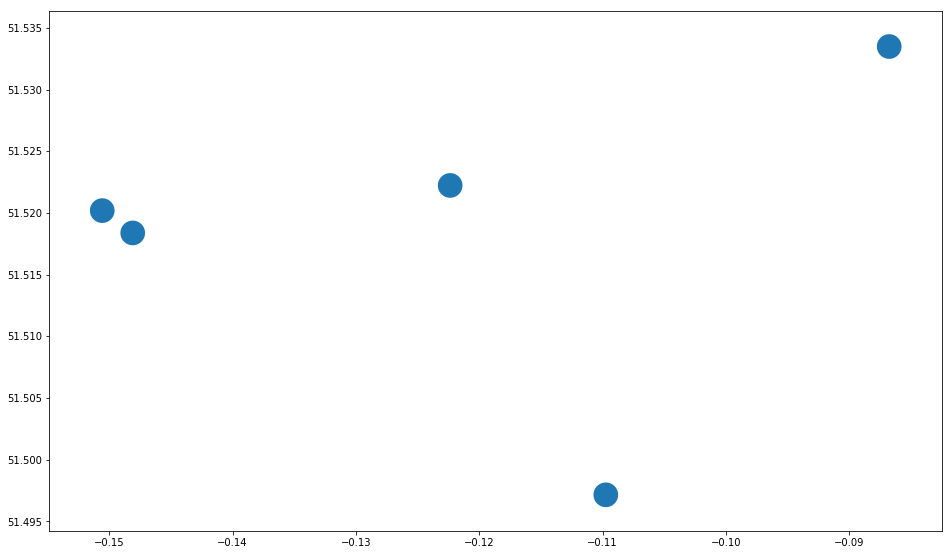

In [15]:
# Create a polygon representing about 100m around each hospital
hospitals['geometry'] = hospitals['geometry'].buffer(0.001)
hospitals.plot()

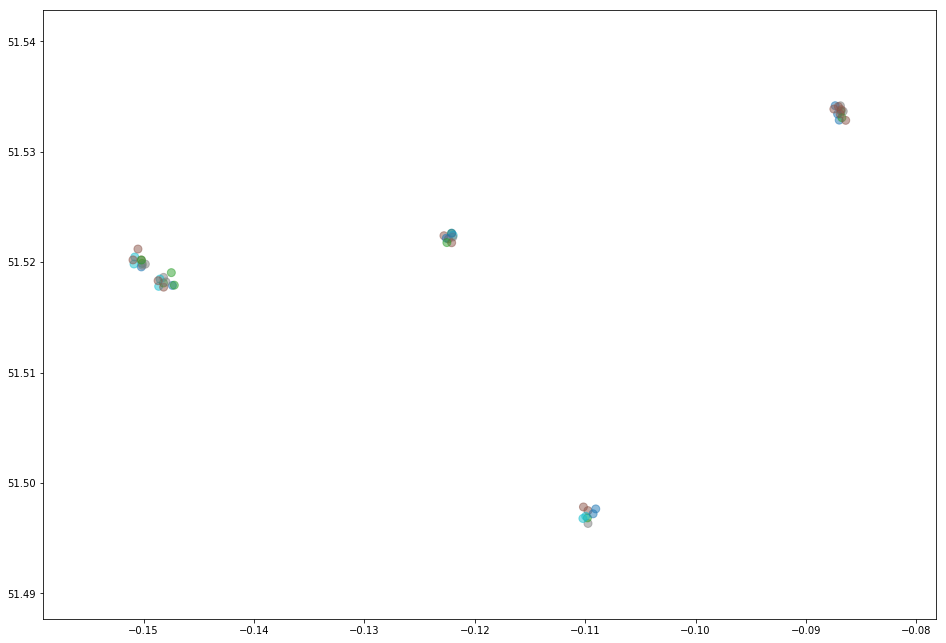

In [16]:
# Join together the hospital zones with the cases
# The "join" is a spatial one - we are joining cases with the hospitals that they are close to
hospital_cases = geopandas.sjoin(
    cases,
    hospitals,
    op='within'
)
hospital_cases.plot(marker="o", column="diagnosis", markersize=64, alpha=0.5)

![Joins](spatial-join.png)

In [17]:
# Now each case that happened in a hospital is associated with the relevant hospital.
hospital_cases[['doctor_name', 'patient_name', 'diagnosis', 'location', 'name']].sample(1)

,doctor_name,patient_name,diagnosis,location,name
48,Steven Ireland,Michael Wagner,typhoid,POINT (-0.1102034513804895 51.49678177158719),Cambian Churchill


### Let's narrow down to cases that didn't happen at hospitals

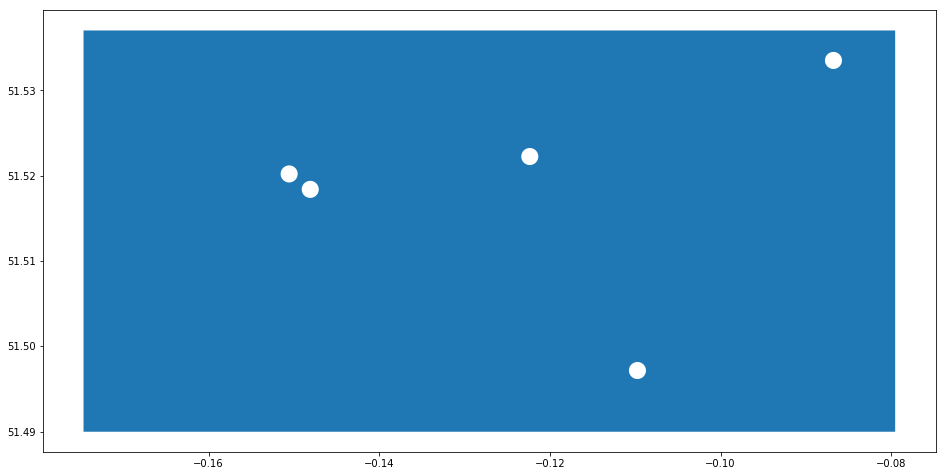

In [18]:
# This is a polygon representing the whole area under study
bounding_box = shapely.geometry.Polygon((
    (WEST, NORTH),
    (EAST, NORTH),
    (EAST, SOUTH),
    (WEST, SOUTH),
    (WEST, NORTH)
))

# This is an area with holes in for each hospital zone
# It will look like a slice of Swiss cheese
minus_hospital_zones = bounding_box.difference(hospitals.unary_union)

area_of_interest = geopandas.GeoDataFrame(
    {
        'geometry': [minus_hospital_zones],
        'name': ['Area of interest']
    },
    crs={'init': 'epsg:4326'}
)
area_of_interest.plot()

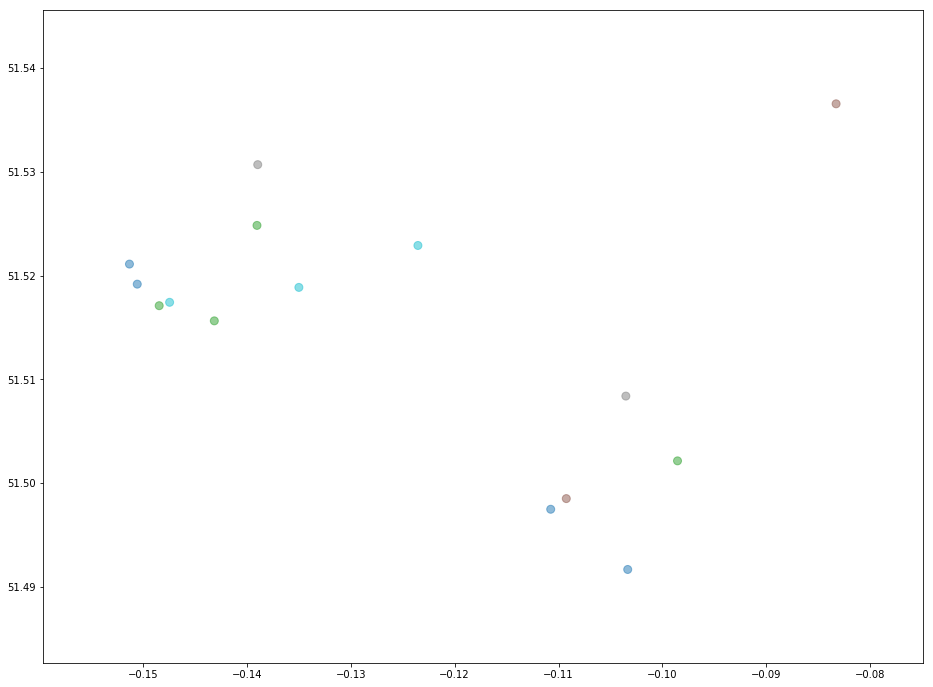

In [19]:
# Now we do another spatial join saying
non_hospital_cases = geopandas.sjoin(cases, area_of_interest, op='within')
non_hospital_cases.plot(marker="o", column="diagnosis", markersize=64, alpha=0.5)

### And let's pull everything together

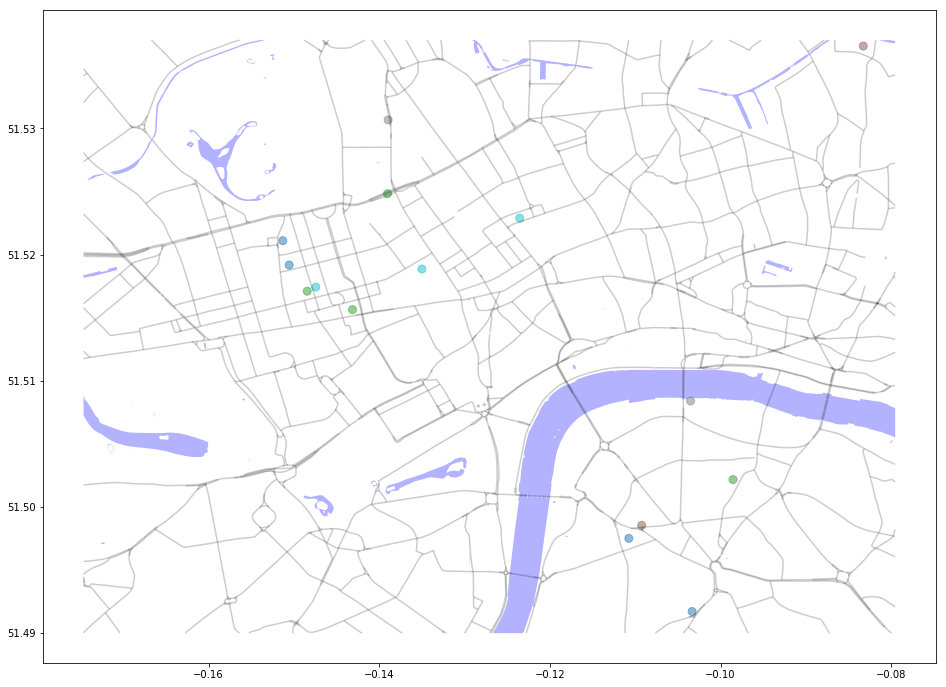

In [20]:
plot_outbreak()

# Day 2
### Not so peaceful

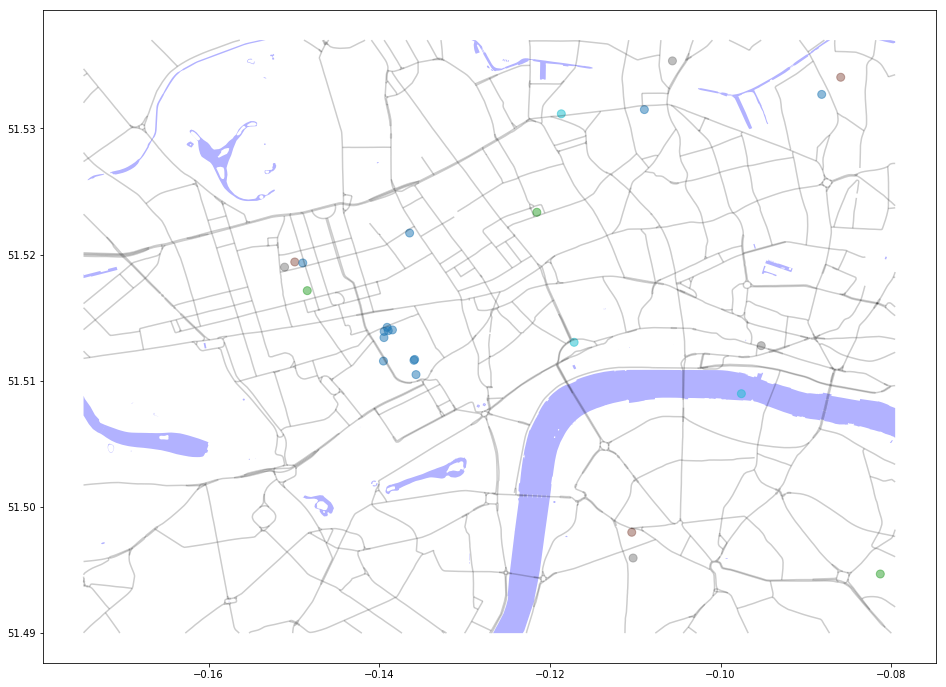

In [21]:
simulation.gather_reports_for_day_2()
plot_outbreak()

### If I was John Snow, I would investigate...

# Day 3

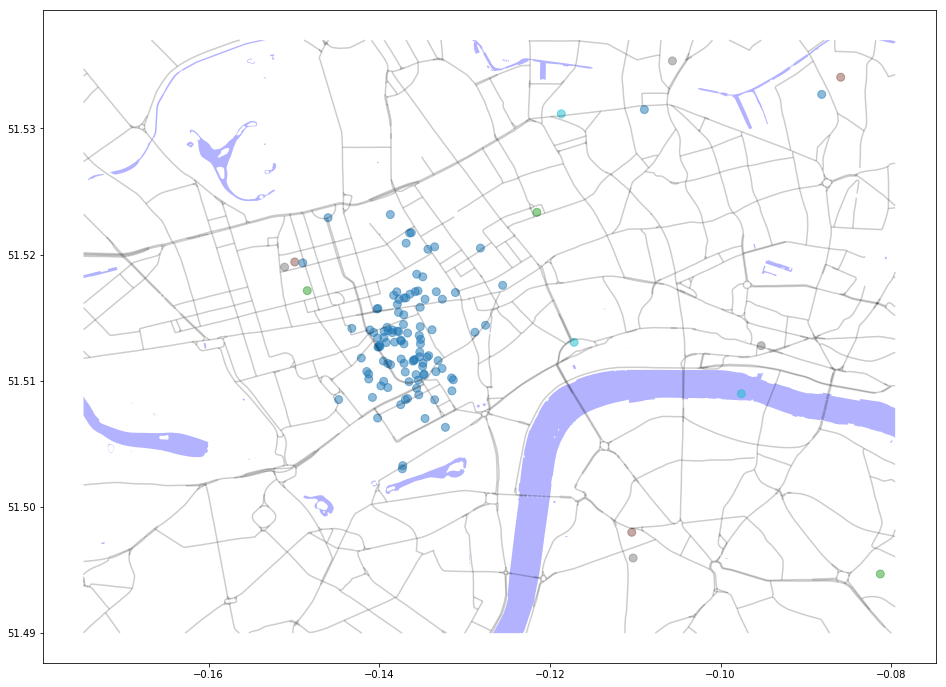

In [23]:
simulation.gather_reports_for_day_3()
plot_outbreak()

# 28 days later

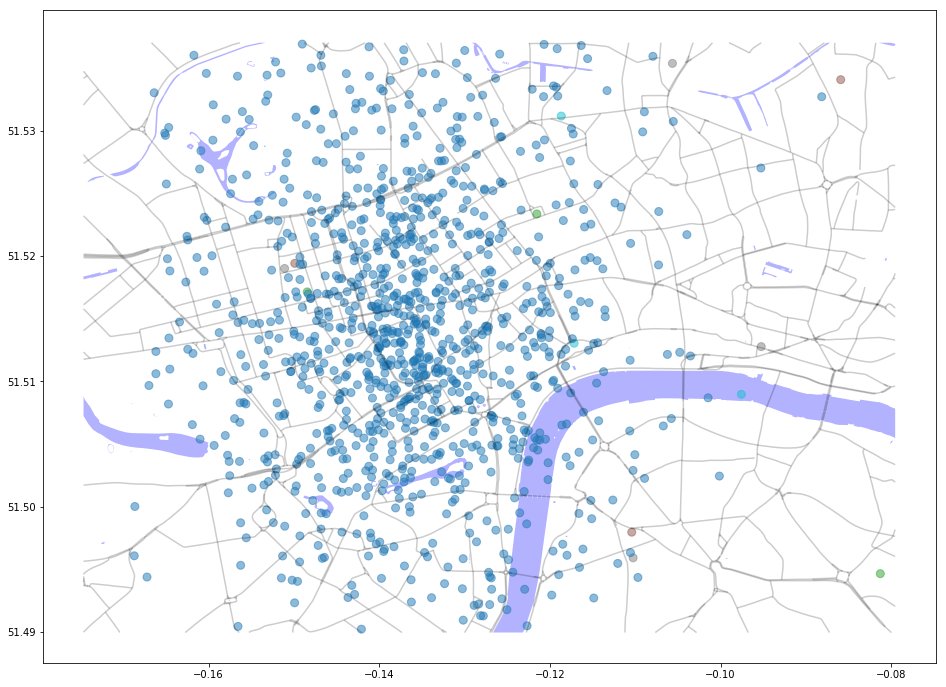

In [24]:
simulation.gather_reports_for_day_28()
plot_outbreak()

# What else could we do?

## Use clustering algorithms to automatically detect outbreaks

Clustering algorithms could detect related diagnoses and give advance warning without human monitoring.

-----------

## Import data from APIs to find the source of an outbreak

Once we've spotted a cluster, we could import data on the kind of businesses in the area to spot e.g. a food poisoning outbreak.

-----------

## Use historic data to train an AI to recognise outbreaks

If we build up enough examples of outbreaks we could train a classifier to spot them.

-----------
